## Autores: 
Blanco García, Gabriel: gabriel.blanco@cunef.edu   
Ferrín Meilá, Michelle: michelle.ferrin@cunef.edu

# Métricas e interpretabilidad: explorando el modelo

<img src='https://www.activemedia.com/sites/default/files/media/media/data-quality-metrics_0.png' width=500>

En este notebook se calculan todas las métricas relevantes del modelo ganador, y también se explican los resultados y las predicciones utilizando `shap`.

In [1]:
# Operaciones básicas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scikitplot as skplt
import pickle

# Explicabilidad 
import shap

# Tratamiento del modelo ganador
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Métricas
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

# Nuestras funciones
%run ../src/operar_modelos.ipynb
%run ../src/plots_metricas.ipynb

## Carga de los datos

In [2]:
X_train = pd.read_pickle('../data/train/X_train.sav')
y_train = pd.read_pickle('../data/train/y_train.sav')

X_validation = pd.read_pickle('../data/validation/X_validation.sav')
y_validation = pd.read_pickle('../data/validation/y_validation.sav')

X_test = pd.read_pickle('../data/test/X_test.sav')
y_test = pd.read_pickle('../data/test/y_test.sav')

Cargamos el modelo optimizado

In [3]:
regresion_logistica = cargar_modelo('../models/trained_models/classifiers/logit_optimizada.sav')

##  Métricas: regresión logística

Comenzamos con un report que recoja las métricas habituales. Calculamos las predicciones tanto en términos de grupo como en términos de probabilidad, puesto que las emplearemos en diversas métricas.

In [6]:
y_pred = regresion_logistica.predict(X_test)
y_pred_proba = regresion_logistica.predict_proba(X_test)

In [13]:
# Calculamos el report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5013
           1       0.89      0.90      0.89      4987

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Las métricas son bastante buenas en ambas clases, un síntoma de que el modelo funciona bien tanto para detectar reseñas positivas como negativas. El resultado es coherente con la distribución del target, que está prácticamente en equilibrio. Calculamos el accuracy.

In [16]:
round(accuracy(regresion_logistica),3)

0.958

El resultado es muy bueno para tratarse de un modelo tan sencillo. No obstante, el accuracy es una métrica demasiado generalista, así que no es la mejor para evaluar el modelo

### Curva de ganancia acumulada

La curva de ganancia acumulada es una de las mejores representaciones de los modelos de Machine Learning en términos de negocio. Representa gráficamente el porcentaje de la muestra que la empresa necesita revisar (eje x) para obtener una determinada ganancia (eje y), y compara la ganancia con la ausencia del modelo, que se representa en la diagonal.

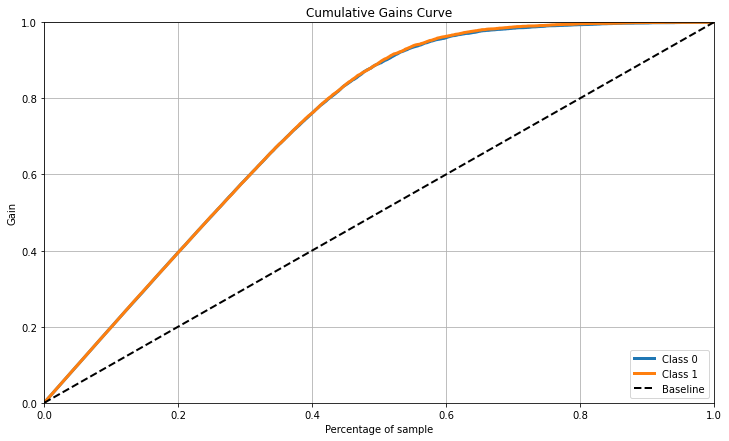

In [39]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba, figsize=(12, 7));

Revisando un 60% de las reseñas, podemos capturar aproximadamente el 95% de las reviews negativas, y tomar medidas para contentar a los clientes. El gráfico se solapa porque el modelo funciona prácticamente igual en ambas clases, tanto positvias como negativas.

### Matriz de confusión y matriz de costes

- La matriz de confusión representa gráficamente como se distribuyen los aciertos y los errores del modelo. En ella representamos tanto los totales como los totales normalizados por filas, que representan las tasas de cada error/acierto
  
  
- La matriz de costes es la versión de la matriz de confusión que cuantifica economicamente cada tipo de clasificación. La representamos con los costes que hemos definido al principio del trabajo

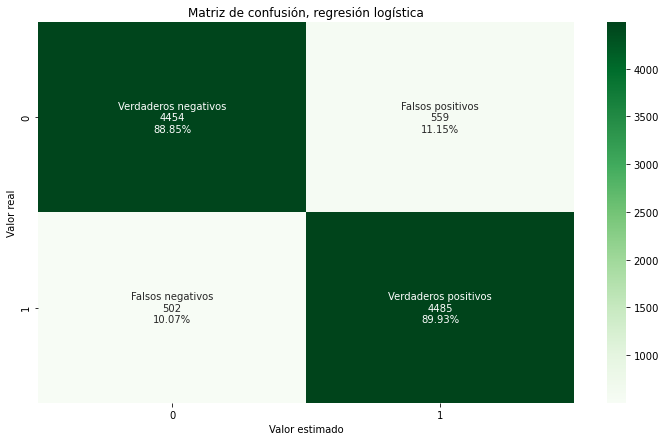

In [11]:
plot_matriz_confusion(regresion_logistica, 'Matriz de confusión, regresión logística')

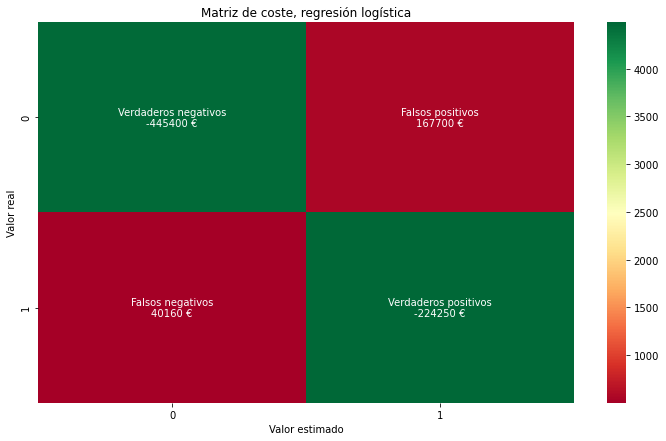

In [12]:
plot_matriz_coste(regresion_logistica, 'Matriz de coste, regresión logística')

Vemos que pese a tener una tasa de falsos postivos y negativos similar (matriz de confusión) el coste es muy superior en el caso de los falsos positivos (matriz de costes), puesto que para el caso de uso del trabajo hemos considerado a los falsos positivos como el caso a evitar a toda costa, y les hemos asignado un coste elevado.

Con todo, el modelo optimizado consigue generar más ingresos que pérdidas, y sale rentable.

### Curva ROC y área bajo la curva

La matriz de confusión está representada con un threshold del 0.5, que es el umbral de probabilidad para el cual se clasifica cada observación como perteneciente a un grupo u a otro. Sin embargo, distintos valores de ese threshold proporcionan distintos valores de tasas de verdaderos positivos y de falsos negativos.

- En el caso más extremo, con threshold 1, todas las observaciones se clasificarian como negativas, y la tasa de falsos positivos sería 0, pero no se lograría ningun verdadero positivo, así que su tasa sería 0.  


- Análogamente, si el threshold es 0, todas las reviews se clasificarian como positivas. La tasa de verdaderos positivos sería 1, porque se capturaría todos, pero la de falsos positivos tambien, porque todos los negativos quedarían clasificados como positivos.

La curcva ROC representa precisamente las distitntas combinaciones de verdaderos positivos y falsos positivos para todos los nivels de threshold. 

Así, cuanto mayor sea el área de la curva ROC, mejor será el modelo.

Representamos la curva roc de la regresión logística

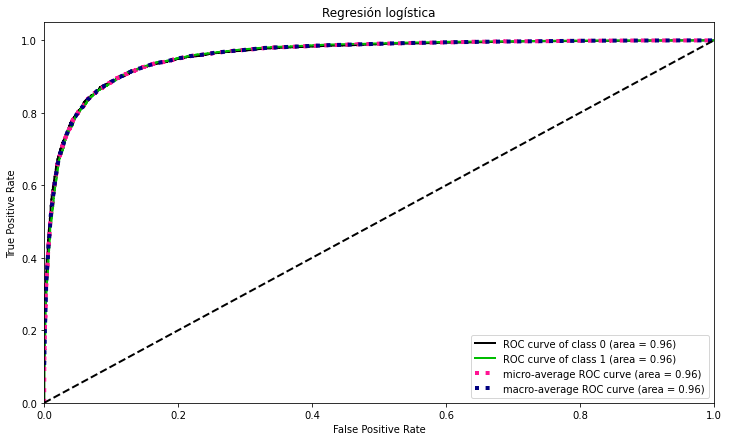

In [14]:
grafico_roc(regresion_logistica, 'Regresión logística')

Vemos que el área es la misma para ambas clases. También se puede calcular el threshold óptimo

El umbral óptimo es 0.89


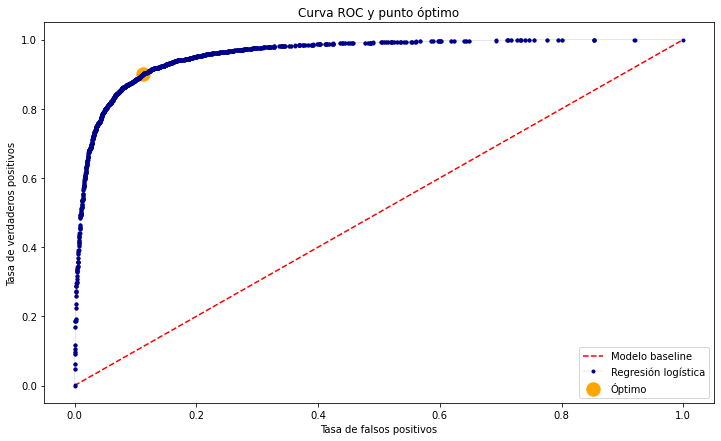

In [15]:
roc_punto_optimo(regresion_logistica, 'Regresión logística')

La representación muestra que el threshold óptimo para este caso de uso sería 0.89. Es decir, que solo se clasificasen como positivas aquellas reseñas que tuviesen una probabilidad de ser positivas de 0.89 o más.

### Precisión y recall

La precisión y el recall se evalúan con la f1 score. Esta métrica combina la precisión y el recall del modelo, y se define como la media harmónica de ambas, siendo útil para representar las dos métricas combinadas.

Se emplea para conocer no solo cuanto acierta el modelo (precisión) sino cuantos verdaderos positivos está capturando del total de verdaderos positivos (recall, exhaustividad). Un buen modelo presenta alta precisión pero también un nivel alto de recall. Por ende, intersan modelos con una puntuación F1 elevada.

La curva precisión-recall muestra el tradeoff entre precisión y recall para los diferentes umbrales de probabilidad

El nivel de probabilidad que optimiza la F1  es 0.9


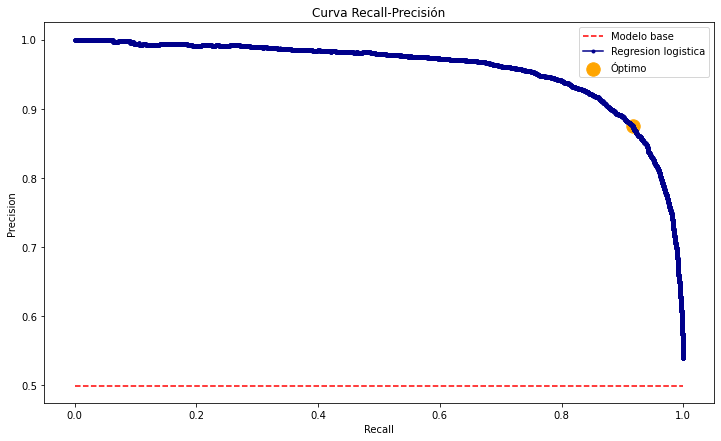

In [16]:
precision_recall_punto_optimo(regresion_logistica, 'Regresion logistica')

Un modelo con altos niveles de recall pero poca precisión captura muchos de los verdaderos positivos, pero muchos de ellos los clasifica de manera incorrecta, y viceversa.  El modelo ideal presenta altos niveles de recall y precisión, capturando un gran numero de verdaderos positivos y clasificándolos correctamente. Vemos que el umbral que optimiza la f1 en nuestro mnodelo es el 0.9. 

### Curva lift

El lift es una medida de la efectividad del modelo. Se calcula como la ratio de los resultados obtenidos con el modelo predictivo y sin el. La cruva representa los distintos valores lift par el porcentaje de muestra revisada. A mayor área bajo la lift, mejor, porque significa que el modelo es muy superior al modelo base 

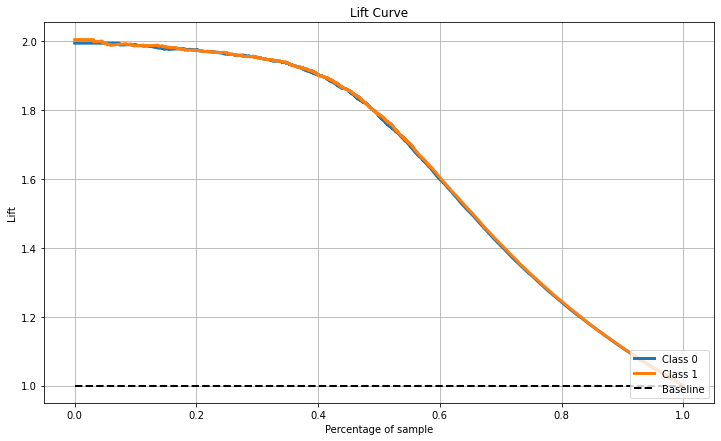

In [17]:
skplt.metrics.plot_lift_curve(y_test, y_pred_proba, figsize=(12, 7));

Los valores lift muestran que el modelo supera al modelo base para un amplio rango de muestra revisdada, lo que verifica que el modelo cumple bien su función. La interpretación de la curva es similar a la de la curva de ganancia acumulada

# Interpretación del modelo

Finalmente, la explicabilidad. Explicar los modelos, entenderlos, y explicar sus predicciones es crítico, por tres motivos básicos:
- __Motivos éticos__: los modelos pueden emplearse en tomas de decisiones sensibles, como puede ser la concesión de una beca, una hipoteca, o el tratamiento de una enfermedad. Cuanto más delicada sea la situación, más importante sera vigilar y explicar el modelo y sus decisiones.
  
  
- __Motivos económicos__: cuanto mejor se comprende un modelo, más fácil es detectar su anomalías, solucionarlas y evitar pérdidas.
  
  
- __Motivos legales__: la creciente regulación en torno a los modelos de Machine Learning hace que haya que tener especial cuidado con las decisiones que se toman y por qué. Las multas se calculan sobre el porcentaje de beneficios de la empresa, y un pequeño error, o no ser capaz de explicar el modelo al legislador, puede significar la quiebra.

## Entender el modelo

Primero es necesario entender el modelo desde el punto de vista teórico y matemático. Esta parte no es indispensable desde el punto de vista práctico, pero ayuda.

En la regresión logísitca, la probabilidad de pertenencia a uno de los dos grupos, para unos valores de ${x_{i}}$, viene determinada por la siguiente ecuación, que se compone de dos términos

$${P\left({c_{i}}|{x_{i}}\right)} = \left[logit^{-1}\left(\alpha + \beta^\tau\right)\right]^{c_{i}} \times \left[1-logit^{-1}\left(\alpha + \beta^\tau\right)\right]^{1-{c_{i}}}$$

donde ${c_{i}}$ es el label de cada grupo, 1 para el caso positivo, y 0 para el negativo. Así, la probabilidad de pertenencia al grupo positivo para una observación ${i}$ con unas características ${x_{i}}$ viene dada por 

$${P\left({c_{i}}=1|{x_{i}}\right)} = \frac{1}{1 + e^{-(\alpha + \beta^\tau{x_{i}})}} = logit^{-1}\left(\alpha + \beta^\tau{x_{i}}\right)$$ 

porque si ${c_{i}}$ vale 1, el exponente del segundo término vale 0, y el término elevdo a 0 vale 1. Para valores elevados de ${(\alpha + \beta^\tau{x_{i}})}$, el numero e vale poco, y el cociente de la ecuación se acerca a 1



Análogamente, la probabilidad de pertenencia al grupo negativo para una observación ${i}$ con unas características ${x_{i}}$ viene dada por:

$${P\left({c_{i}} = 0|{x_{i}}\right)} = 1- logit^{-1}\left(\alpha + \beta^\tau{x_{i}}\right)$$

porque si ${c_{i}}$ vale 0, el término que se cancela es el primero. Y para valores reducidos de ${(\alpha + \beta^\tau{x_{i}})}$, el denominador (con la ecuación en forma de fracción) es superior al numerador, y el cociente tiende a 0.

## Entender las predicciones

<img src='https://docs.seldon.io/projects/alibi/en/stable/_images/shap_cartoon.png' width=700>

Para explicar el modelo dede el punto de vista práctico, utilizamos el explainer `shap`

El explainer no funciona con pipelines, así que lo primero es extraer el modelo

In [4]:
# Primero extraemos el mejor modelo 
mejor_modelo = regresion_logistica.best_estimator_

# y despues extraemos el clasificador, separandolo del vectorizador
regresion_logistica = mejor_modelo.named_steps['clasificador']

In [5]:
# El modelo 
regresion_logistica

LogisticRegression(C=10, solver='saga')

Inicializamos shap

In [5]:
shap.initjs()

Necesiaremos guardar una copia del texto sin vectorizar

In [6]:
texto_test = X_test # Esto hace falta para mantener el texto

Hay que volver a vectorizar los datos manualemente, porque al vectorizarse en el pipeline, no se guardan

In [7]:
# Inicializamos el vectorizador y vectorizamos los datos
vectorizador = TfidfVectorizer()

X_train = vectorizador.fit_transform(X_train)
X_test = vectorizador.transform(X_test)

In [8]:
# Extraemos el nombre de las variables
nombre_variables = vectorizador.get_feature_names()

Construimos el explainer, que por las características del modelo, es lineal. Con el explainer, calculamos la puntuación shap

In [9]:
explainer = shap.LinearExplainer(regresion_logistica, X_train, feature_perturbation='interventional')
puntuacion_shap = explainer.shap_values(X_test)

In [10]:
X_test_array = X_test.toarray() # es necesario pasarlo a vector para utilizarlo con los plots

# Como el array tiene los índices mezclados, hay que resetearlos tambien en el texto de test, si no
# las explicaciones después se complican
texto_test.reset_index(drop=True, inplace=True) 

# Sucede lo mismo con la y
y_test.reset_index(drop=True, inplace=True)

# El problema se debía a que los índices no fueron reiniciados después de barajar los dateset

### Explicación global

Primero nos centramos en cuales son las variables que, de manera global, más afectan al output. En este caso, cuales son las palabras que resultan determinantes a la hora de clasificar una review. Utilizamos el summary plot

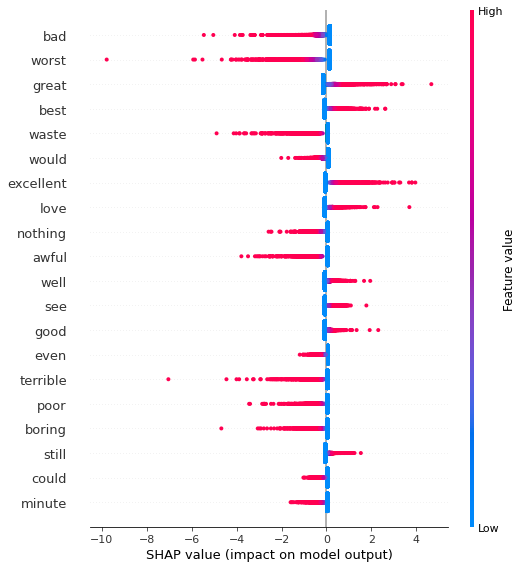

In [52]:
shap.summary_plot(puntuacion_shap, X_test_array, nombre_variables)

Vemos como contribuye cada una de las palabras más representantivas. Al haber utilizado Tf-Idf. hemos contrarrestado el efecto de palabras como movie o film, que se repetían mucho por el tema general de las reseñas, pero que no aportaban información real al análisis de sentimientos. Esas palabras que en wordcloud inicial se mostraban como muy importntes ya no aparecen aquí.

Los resultados son coherentes y concuerdan con los wordcloud del EDA. Palabras como bad y worst tienen un impacto negativo en el sentimiento, mientras que otras como great y excellent afectan positivamente.

También se hace notable la polaridad que se anticipaba con VADER, puesto que la mayoría de las palabras que muestra el summary_plot contribuyen fuertemente en su correspondiente direccion

### Explicación local

La otra clase de explicación importante es la local, que consiste en analizar, para una determinada reseña, clasificada como positiva o negativa, cuáles son las variables que más han influido en la decisión, y en qué dirección han influido.  

Hemos tenido numerosos problemas con la expliación local, empleando el force plot. El problema reside en que este plot no permite limitar el número de variables que se muestran para cada observación, y surge cuando el número de variables que inflyen en una predicción se dispara, como es el caso del texto.

Más concretamente, shap intenta representar todas las variables, la memoria RAM llega a niveles del 95% (ordenador con 16gb) e imposibilita el trabajo, poniendo en peligro el ordenador.

Por ello, la solución consite en resrtingir manualmente el número de variables que se quieren tener en cuenta en el force plot, como se expone a continuación de manera detallada

In [34]:
puntuacion_shap.shape

(10000, 151074)

El objeto con la puntuación shap consta de 10.000 filas, que es la longitud del tramo de test, y 151074 columnas, que son nada más y nada menos que el total de variables (palabras) que existen en este dataset. Este tipo de problmeas se puede prevenir fijando un threshold en la vectorización, que sea una relevancia mínima que cada palabra necesite cumplir como para ser tenida en cuenta en el vocabulario. Aún así, el número de variables en problemas de texto puede ser muy elevado, así que lo recomendable es filtar igualmente las variables a tener en cuenta para el plot, puesto que con más de 30 variables, el plot queda inservible. Ademád, de este modo se puede inspeccionar cómo varía el output si se consideran más o menos variables

Primero se explica el proceso paso a paso, y después se encapsula todo en una función, con el objetivo de poder explicar rápidamente distintas variables, modificar parámetros fácilmente, y reutilizar la función en futuros proyectos

Se calcula la suma, en valor absoluto, de los valores shap por columnas.  

In [23]:
suma_valores_shap = np.abs(puntuacion_shap).sum(axis=0) # suma por columna de valores shap
suma_valores_shap.shape # cada fila contiene la suma de los shap de cada variable

Se obtien los índices que ordenarian el array, con `np.argsort()`.  

In [12]:
valores_shap_ordenados = np.argsort(suma_valores_shap)[::-1]

Se define el número de variables que se van a considerar para el force_plot, en este caso 20.  

In [13]:
top_variables_importantes = 20
variables_importantes = list(valores_shap_ordenados.flatten()[::top_variables_importantes]) # son los indices

In [33]:
[nombre_variables[codigo] for codigo in variables_importantes][0:5] # muestra

['bad', 'life', 'plot', 'woman', 'highly']

Se extrae, de las puntuaciones generales, la puntuación de la predicción que se quiere explicar, en este caso la 5.  

In [14]:
valores_shap_observacion = puntuacion_shap[5]

De ese usario, se extraen los índices que ordenan las puntuaciones para sus variables, similar al paso 2 con todas las variables. Se determinan el número de variables positivas y negativas a considerar.  

In [15]:
indices_valor_shap_observacion = np.argsort(valores_shap_observacion) # de menor a mayor
variables_a_considerar = 10 # variables a considerar

Se extraen, tanto para las contribuciones positivas como negativas, el nombre de la variable, el valor shap, y el índice.  

In [16]:
# Para las negativas
neg_cols = [nombre_variables[indices_valor_shap_observacion[codigo]] for codigo in range(variables_a_considerar)]

neg_vals = [valores_shap_observacion[indices_valor_shap_observacion[codigo]] for codigo in range(variables_a_considerar)]

neg_indexes = [indices_valor_shap_observacion[codigo] for codigo in range(variables_a_considerar)]

In [17]:
# Para las positivas
pos_cols = [nombre_variables[indices_valor_shap_observacion[-(codigo + 1)]] for codigo in range(variables_a_considerar)]

pos_vals = [valores_shap_observacion[indices_valor_shap_observacion[-(codigo + 1)]] for codigo in 
                                                                                          range(variables_a_considerar)]

pos_indexes = [indices_valor_shap_observacion[-(codigo + 1)] for codigo in range(variables_a_considerar)]

Este es el aspecto que tienen los objetos que acabamos de generar

In [57]:
print(neg_cols, neg_vals, neg_indexes)
print(pos_cols, pos_vals, pos_indexes)

['crappy', 'predictable', 'flat', 'neither', 'excuse', 'annoyed', 'unnecessary', 'wonder', 'either', 'original'] [-1.0343174385543754, -0.7712816793975967, -0.6416931909425757, -0.6138928670829011, -0.5251305409821707, -0.3820479704962548, -0.37101685884732416, -0.35040247108819855, -0.346390594103716, -0.3128930895078234] [31196, 104366, 50690, 91178, 45860, 8539, 140506, 147981, 42065, 96394]
['classic', 'best', 'small', 'romance', 'budget', 'see', 'smooth', 'bad', 'man', 'new'] [0.5043474680541984, 0.4851786410708989, 0.31524535378947066, 0.2905484030702938, 0.19868965142149306, 0.18419472230224376, 0.16722866972267733, 0.1498152889292964, 0.14891509851681578, 0.14736393836920392] [26330, 15605, 122544, 113019, 20261, 117227, 122739, 12648, 81400, 91476]


Se crea un objeto que contenga los índices de las positivas y de las negativas, que se utilizará para filtrar las variables totales.  

In [18]:
variables_principales = neg_indexes[:] # las negativas
variables_principales.extend(pos_indexes[:]) # las positivas 

variables_principales # El resultado es una lista con los 20 índices de las columnas de interés, 
                      # 10 positivas y 10 negativas

[31196,
 104366,
 50690,
 91178,
 45860,
 8539,
 140506,
 147981,
 42065,
 96394,
 26330,
 15605,
 122544,
 113019,
 20261,
 117227,
 122739,
 12648,
 81400,
 91476]

Se extraen los nombres de esas variables, utilizando sus índices como filtro.  

In [19]:
nombre_variables_principales = [nombre_variables[i] for i in variables_principales]
nombre_variables_principales

['crappy',
 'predictable',
 'flat',
 'neither',
 'excuse',
 'annoyed',
 'unnecessary',
 'wonder',
 'either',
 'original',
 'classic',
 'best',
 'small',
 'romance',
 'budget',
 'see',
 'smooth',
 'bad',
 'man',
 'new']

Finalmente, se realiza el plot de fuerza de la siguiente manera:    
  
  
    1. Se filtran las puntuaciones shap, para la fila de interés, y para las columnas elegidas (20)
    2. Se filtra el objeto de test, para la fila de interés y para las columnas elegidas(20)

In [20]:
observacion = 5
shap.force_plot(explainer.expected_value, 
               puntuacion_shap[observacion, variables_principales],
               X_test_array[observacion, variables_principales],
               feature_names=nombre_variables_principales,
               link='logit') # con link='logit', el valor f(x) se transforma a probabilidad

Imprimirmos el texto de la review para compararlo con el gráfico e interpretar la explicación

In [223]:
print('Valor real: reseña', 'postivia:' if y_test[observacion] == 1 else 'negativa:')
print(texto_test[observacion])

Valor real: reseña negativa:
unnecessary movie character acting unsympathetically really didnt care would fare best purpose film portray smooth talking coldhearted new york city folk romance comedy either acting flat predictable plot annoyed constant joking quote classic movie man cant see quote le significant movie becomes try original small budget excuse firsttime director neither crappy crappy crappy wonder cost one buck


Vemos las palabras que han contribuido a clasificar la review como negativa, crappy aparece 3 veces en la review, predictiable. La unica palabra positiva es best, y parece que el modelo la ha capturado como positiva fuera de contexto. Aún así, el modelo la ha clasificado correctamente

Como se comentaba arriba, para agilizar el proceso y poder explicar más observaciones, se define una función. Es demsiado código para un solo bloque, pero porque recopila los pasos que se han hecho de manera individual todos en uno

In [21]:
def force_plot_resumido(observacion, 
                        variables=10,
                        link='logit'):
    
    
    top_variables = 20
    top_variables_importantes = top_variables
    variables_importantes = list(valores_shap_ordenados.flatten()[::top_variables_importantes])
    valores_shap_observacion = puntuacion_shap[observacion]
    
    indices_valores_shap = np.argsort(valores_shap_observacion)
    variables = variables

    # Para las negativas
    neg_cols = [nombre_variables[indices_valores_shap[codigo]] for codigo in range(variables)]
    neg_vals = [valores_shap_observacion[indices_valores_shap[codigo]] for codigo in range(variables)] 
    neg_indexes = [indices_valores_shap[codigo] for codigo in range(variables)]
    
    # Para las positivas
    pos_cols = [nombre_variables[indices_valores_shap[-(codigo + 1)]] for codigo in range(variables)]
    pos_vals = [valores_shap_observacion[indices_valores_shap[-(codigo + 1)]] for codigo in range(variables)]
    pos_indexes = [indices_valores_shap[-(codigo + 1)] for codigo in range(variables)]
    
    variables_principales = neg_indexes[:] # las negativas
    variables_principales.extend(pos_indexes[:]) # las positivas     
    nombre_variables_principales = [nombre_variables[i] for i in variables_principales]
    
    
    plot = shap.force_plot(explainer.expected_value, 
                           puntuacion_shap[observacion, variables_principales],
                           X_test_array[observacion, variables_principales],
                           feature_names=nombre_variables_principales,
                           link='logit')
    
    
    print('Valor real: reseña', 'postivia:' if y_test[observacion] == 1 else 'negativa:')
    print(texto_test[observacion])
    return plot

Ahora podemos aplicar la función del force plot resumido a diferentes observaciones. Recordemos que por defecto se valoran 20 variables, 10 de cada sentimiento.

##### Reseña número 10

In [22]:
force_plot_resumido(observacion=10)

Valor real: reseña negativa:
qualify title think checkout entirely worthless ive opportunity see twice second time get great laugh movie expense guess worth something also worthwhile excruciating pain caused first viewing another reviewer pointed film hackneyed every sense word single original thought went movie make comment originality premise entirely baffling film nothing long line cliche strung together paraded around movie definitely next clerk definitely original absolutely good clean fun film absolute agony uninitiated seeing first time second time quite funny insulting sort way looked around theater obvious nearly everyone barring perhaps elderly completely bored pained movie particularly emotional scene like nick chew mother audience actually cringing poorly done even heard someone groan theater something heretofore never witnessed dont care chance see movie film festival indie theater wherever favor skip movie vengeance unless youre like cant resist opportunity see may truly 

La reseña número 10 ha sido correctamente clasificada como negativa, con una probabilidad del 0.13 de ser positiva. Vemos como palabras como _worst_, _poorly_, _bored_ o _insulting_ empujan el output hacia la negatividad, mientras que otras como _great_ y _fun_ lo empujan hacia la positividad, pero con menos fuerza.

##### Reseña número 40

In [23]:
force_plot_resumido(observacion=40)

Valor real: reseña postivia:
best movie seen 2000 beautiful talented natalie portman great storyline cast soundtrack enjoyed much 10 10


La 40 también se clasifica correctamente. Como decíamos, poodemos modificar el número de variables a tener en cuenta. De este modo, se puede hacer análisis de sensibilidad, y ver cómo varía la probabilidad en función de las variables que se consideran. Si solo se considera una variable en cada sentido, el resultado es el siguiente

In [24]:
force_plot_resumido(observacion=40, variables=1)

Valor real: reseña postivia:
best movie seen 2000 beautiful talented natalie portman great storyline cast soundtrack enjoyed much 10 10


Para un threshold del 0.5, la review sería positiva con una probabilidad del 0.72, considerando solo las dos variables más influytentes. Si subimos a 5, la probabilidad aumenta

In [25]:
force_plot_resumido(40, variables=5)

Valor real: reseña postivia:
best movie seen 2000 beautiful talented natalie portman great storyline cast soundtrack enjoyed much 10 10


Este tipo de análisis de sensibilidad es interesante porque permite contrastar aspectos como el número mínimo de variables que necesita el modelo para predecir correctamente una determinada observación, o para los casos dudosos, a partir de qué variable el modelo "cambia de idea" y clasifica como positivo o negativo.

No obstante, no tiene sentido analizar observaciones al azar. Lo que nos interesa es estudiar __dónde falla el modelo y por qué__. En concreto, los falsos positivos, que son el elemento más caro para nuestra empresa

### Análisis de falsos positivos

Cosntruimos un dataframe con los valores reales y predecidos. Recordemos que el threshold está al 0.5.

In [26]:
y_pred = regresion_logistica.predict(X_test)

In [27]:
# Construccion del dataframe
resultados = pd.DataFrame({'real': y_test,
                           'prediccion': y_pred})

In [49]:
resultados

,real,prediccion
0,1,1
1,0,0
2,0,1
3,1,1
4,0,0
...,...,...
9995,1,1
9996,0,0
9997,0,0
9998,1,1


Los __falsos positivos__ se producen cuando el label real es 0, y el predecido es 1. Podemos utilizar este razonamiento para filtrar los resultados, y obtener la tabla solo con los falsos positivos.

In [53]:
falsos_positivos = resultados.real < resultados.prediccion # cuando en realidad es 0, y el modelo dice 1
resultados[falsos_positivos] # filtramos la  tabla

,real,prediccion
2,0,1
29,0,1
36,0,1
38,0,1
54,0,1
...,...,...
9942,0,1
9956,0,1
9960,0,1
9963,0,1


Esos son nuestros 559 falsos positivos, que naturalmente coinciden con la matriz de confusión. Podemos usar sus índices en el plot para ver qué sucede.

##### Falso postivo número 2

In [28]:
force_plot_resumido(observacion=2, variables=15)

Valor real: reseña negativa:
summary say made ignorant comment ever heard rpg seriously thought gay retarded went go save best friend someone decides goodness heart help serious debt man lavitz good person time helped made closer friend werent gay lover like bitching let know game set medieval time period back woman prepare meal men fought even know history know long took woman accepted army present day game contains lot realism even though damn slow obviously catch really need spit solid proof instead ignorant assumption based misguided act interpret story


Vemos que el texto es bastante ambiguo. Palabras como solid, closer y know se han utilizado como palabras positivas. Otras palabras como woman y gay, han empuajdo la review hacia la negatividad. Hay que tener cuidado con este tipo de cosas: __no significa que gay y woman sean cosas malas o palabras negaticas, significa que el modelo ha encontrado una asociación entre la presencia de esas palabras en una review y la clase negativa__. Este tipo de cosas pueden resultar problematicas desde el punto de vista regulatorio, y hay que trararlas con cuidado. 

##### Falso positivo número 38

También es importante vigilar en número de variables. El modelo considera todas. Parece que a veces se confude por considerar demasiadas variables. Quizá la longitud del texto también sea perjudicial.

Considerando 20 variables de cada tipo, la review 38 se clasificaría correctamente, como negativa

In [29]:
# Con 20 variables, se clasificaría bien
force_plot_resumido(observacion=38, variables=20)

Valor real: reseña negativa:
depressed creepy teenager many bad thing socially active older lady like use shade drape window steel assorted thing peep prank call play assorted unpleasant trick oddly keep none secret first seem care one way bothering later seems begin respect cruel fevered activitiesthere illogical item note one guy peep night pane glass brightly lit side real life thing would happen brightly lit side pane glass act mirror would able see exactly nothing also everyone night would able look inside sitting well lit roomone illogical item creepy teen take job milkman one customer morning seems lady picking easy work get iti saw short film love public showing end single open eye house short film love foreign language movie like reading subtitle word spoken film much movie silent certain rest peace


Sin embargo, al aumentar el número de variables a tener en cuenta, el modelo falla, y se clasifica como positiva cuando en realidad es negativa.

In [30]:
# Con 50 variables, es falso positivo
force_plot_resumido(observacion=38, variables=50)

Valor real: reseña negativa:
depressed creepy teenager many bad thing socially active older lady like use shade drape window steel assorted thing peep prank call play assorted unpleasant trick oddly keep none secret first seem care one way bothering later seems begin respect cruel fevered activitiesthere illogical item note one guy peep night pane glass brightly lit side real life thing would happen brightly lit side pane glass act mirror would able see exactly nothing also everyone night would able look inside sitting well lit roomone illogical item creepy teen take job milkman one customer morning seems lady picking easy work get iti saw short film love public showing end single open eye house short film love foreign language movie like reading subtitle word spoken film much movie silent certain rest peace


##### Falso positivo número 54

Nuevamente, con 25 variables o más, el resultado sería falso positvo. Con menos, se clasificaríacorrectamente

In [31]:
force_plot_resumido(observacion=54, variables=25)

Valor real: reseña negativa:
exactly new story line romantic comedy make concept work young manjohn cusack drop dead gorgeous womankate beckinsalekeep meeting chance wonder meant although promised othersoddly enough still feel soul mate somewhere little sappy place viva la love romantic almost obligated riveted favorite scene cusack ground snow start falling finale almost sweet deserving one cusacks deeper role hell could smitten beckinsale notable support provided jeremy piven molly shannon john corbett play worst role ive ever seen hand eugene levy quirky funny watch soul mate


In [32]:
force_plot_resumido(observacion=54, variables=15)

Valor real: reseña negativa:
exactly new story line romantic comedy make concept work young manjohn cusack drop dead gorgeous womankate beckinsalekeep meeting chance wonder meant although promised othersoddly enough still feel soul mate somewhere little sappy place viva la love romantic almost obligated riveted favorite scene cusack ground snow start falling finale almost sweet deserving one cusacks deeper role hell could smitten beckinsale notable support provided jeremy piven molly shannon john corbett play worst role ive ever seen hand eugene levy quirky funny watch soul mate


Esta variación en el output al cambiar el número de variable a considerar no es tan abrupta en las reviews correctamente clasificadas, donde aunque se varíe el número de variables, la clasificación no cambia. Solo sucede en el caso de los faslso positivos, que son textos más ambiguos con los que el modelo tiene problemas. 

Se podrían seguir revisando todos los falsos positivos, el procedimiento es el mismo. Este mismo análisis aplica también para los falsos negativos, y los distintos positivos. Los filtros serían:

- Falsos negativos: `resultados.real > resultados.prediccion`

- Verdaderos positivos: `resultados.real + resultados.prediccion == 2`   

- Verdaderos negatiuvos: `resultados.real + resultados.prediccion == 0`

Nos hemos centrado en los falsos negativos porque son la clase que más coste genera para la empresa en este caso de uso.

# Conclusiones

En este proyecto, hemos tenido la oportunidad de trabajar con información no estructurada, en formato texto. Hemos aprendido los distintos mecanismos mediante los cuales se consigue que los modelos de Machine Learning, sea cual sea el tipo, puedan trabajar con datos de texto. 

Para estos proyectos, es crucial la limpieza de los datos, para garantizar la calidad de los resultados, así como seleccionar bien los métodos de vectorización. Cambios sensibles en el prepreocesamiento pueden tener grandes repercusiones en el resultado final.

De entre todos los modelos que se han construido, el que mayor valor económico genera es la regresión logística. Pese a la simpleza del modelo, los resultados que ofrece son de alta calidad, algo que combinado con su bajo coste computacional ha hecho que al final nos decantásemos por ese modelo como modelo ganador, incluso por delante de redes neuronales que ofrecían resultados sensiblemente mejores. Valorando los modelos en conjunto, es decir, no solo las métricas, sino también su coste y su valor económico, el modelo que más se adecúa a este problema es sin duda la regresión logística. 

Asimismo, una buena práctica consiste en plantear el problema en términos económicos, definiendo como mínimo cuanto ingreso/coste genera cada tipo de predicción de los modelos. Esto permite tener presente durante todo el proceso el valor económico y el negocio, para poder comparar los modelos en términos de economía real, y no solo con métricas matemáticas. 

Finalmente, hemos tratado de expandir la interpretabilidad, programando una función que permita visualizar el efecto que tiene considerar más o menos variables para cada predicción. Hemos intentado construir un dashboard con `panel`, para que el análisis fuese todavía más inmediato, pero no ha sido posible, por problemas de integración entre los outputs de `panel` y el forceplot de `shap`. No obstante, la función porgramada cumple su fin, y permite probar distintas variables para cada observación. Esta posibilidad facilita el análisis de los errores del modelo. Se pueden explorar más facilmente los falsos positivos y tratar de entender por qué el modelo falla.

En cuanto al procesamiento del lenguaje natural o NLP, es un campo apasioannte del que apenas hemos arañado la superficie. Uno de los retos de esta disciplina es conseguir que los modelos entiendan el contexto, puesto que los clasificadores que hemos construido, en el fondo, son muy simples. Tratan las palabras de manera aislada, asumiendo que no existe interdependencia entre ellas, cuando en la vida real esa dependencia está presente constantemente. Aún así, los resultados que se pueden obtener de manera relativamente sencilla aplicando NLP son alentadores, no solo desde el punto de vista del aprendizaje supervisado, sino también desde el semi supervisado (por ejemplo, VADER)

En síntesis, consideramos que efectivamente se pueden combinar las técnicas de text mining, NLP y Machine Learning para generar valor añadido a las empresas, siendo útiles para una infinidad de problemas, como por ejemplo, el caso de este proyecto, el análisis de semtimientos.